<a href="https://colab.research.google.com/github/Bassam-Alswehry/temporal-analysis-of-urban-areas-using-computer-vision-part4/blob/main/temporal_analysis_of_urban_areas_part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Part 1 — Temporal Change Engine

import cv2
import numpy as np

def resize_image(img, size=(640, 360)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

def compute_change_metrics(img_base_bgr, img_cmp_bgr):
    base_g = cv2.cvtColor(img_base_bgr, cv2.COLOR_BGR2GRAY)
    cmp_g  = cv2.cvtColor(img_cmp_bgr,  cv2.COLOR_BGR2GRAY)

    brightness_diff = float(abs(base_g.mean() - cmp_g.mean()))
    sharpness = float(cv2.Laplacian(cmp_g, cv2.CV_64F).var())

    edges1 = cv2.Canny(base_g, 50, 150)
    edges2 = cv2.Canny(cmp_g,  50, 150)
    edge_change = float(np.mean(cv2.absdiff(edges1, edges2)) / 255.0)

    mse = np.mean((base_g.astype(np.float32) - cmp_g.astype(np.float32)) ** 2)
    ssim_like = float(1.0 / (1.0 + mse / 1000.0))
    ssim_change = 1.0 - ssim_like

    if brightness_diff > 25:
        w_edges, w_ssim = 0.90, 0.10
    elif sharpness > 300:
        w_edges, w_ssim = 0.60, 0.40
    else:
        w_edges, w_ssim = 0.75, 0.25

    change_score = float(w_edges * edge_change + w_ssim * ssim_change)

    return {
        "brightness_diff": brightness_diff,
        "sharpness": sharpness,
        "edge_change": edge_change,
        "ssim": ssim_like,
        "ssim_change": ssim_change,
        "w_edges": w_edges,
        "w_ssim": w_ssim,
        "change_score": change_score
    }

def run_part1_engine(before_bgr, after_bgr):
    before = resize_image(before_bgr)
    after  = resize_image(after_bgr)

    metrics = compute_change_metrics(before, after)
    score = metrics["change_score"]

    if score >= 0.22:
        decision = "High"
        action = "Investigate immediately"
    elif score >= 0.12:
        decision = "Medium"
        action = "Review and confirm"
    else:
        decision = "Low"
        action = "No action required"

    return {
        "metrics": metrics,
        "decision_priority": decision,
        "recommended_action": action
    }

# Part 4 — Toolization (MVP)

Workflow:
Upload two images → Run Part 1 Engine → Decision + Visualization

Part 1 = Core Engine  
Part 4 = Tool / Interface

In [3]:
from google.colab import files
import numpy as np
import cv2

print("Upload TWO images (Before then After)")
uploaded = files.upload()

keys = list(uploaded.keys())
if len(keys) < 2:
    raise ValueError("Upload exactly TWO images")

before_key, after_key = keys[0], keys[1]

before_arr = np.frombuffer(uploaded[before_key], np.uint8)
after_arr  = np.frombuffer(uploaded[after_key],  np.uint8)

before_bgr = cv2.imdecode(before_arr, cv2.IMREAD_COLOR)
after_bgr  = cv2.imdecode(after_arr,  cv2.IMREAD_COLOR)

if before_bgr is None or after_bgr is None:
    raise ValueError("Invalid images")

print("Before:", before_key, before_bgr.shape)
print("After :", after_key, after_bgr.shape)

Upload TWO images (Before then After)


Saving barcelona_dense02_2014.png to barcelona_dense02_2014.png
Saving barcelona_dense02_2017.png to barcelona_dense02_2017.png
Before: barcelona_dense02_2014.png (666, 1920, 3)
After : barcelona_dense02_2017.png (665, 1920, 3)


In [5]:
result = run_part1_engine(before_bgr, after_bgr)
result

{'metrics': {'brightness_diff': 9.610164930555555,
  'sharpness': 824.3919809909208,
  'edge_change': 0.19918836805555556,
  'ssim': 0.18968798220157623,
  'ssim_change': 0.8103120177984238,
  'w_edges': 0.6,
  'w_ssim': 0.4,
  'change_score': 0.44363782795270285},
 'decision_priority': 'High',
 'recommended_action': 'Investigate immediately'}

In [6]:
m = result["metrics"]

print("=== Part 4 Output ===")
print("Decision Priority :", result["decision_priority"])
print("Recommended Action:", result["recommended_action"])
print("Change Score      :", round(m["change_score"], 4))

=== Part 4 Output ===
Decision Priority : High
Recommended Action: Investigate immediately
Change Score      : 0.4436


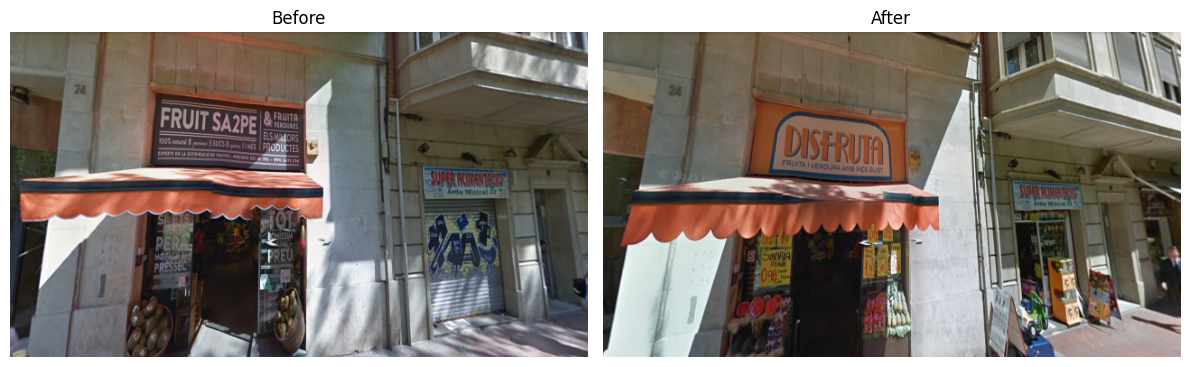

In [7]:
import matplotlib.pyplot as plt

before_rs = resize_image(before_bgr)
after_rs  = resize_image(after_bgr)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(before_rs, cv2.COLOR_BGR2RGB))
plt.title("Before")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(after_rs, cv2.COLOR_BGR2RGB))
plt.title("After")
plt.axis("off")

plt.tight_layout()
plt.show()

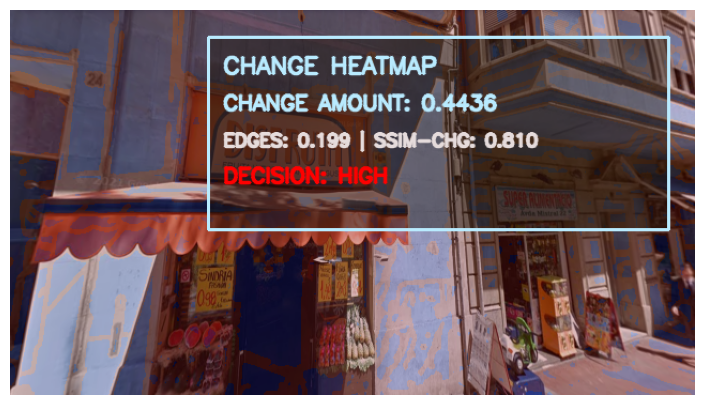

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Base images (resized)
before_rs = resize_image(before_bgr)
after_rs  = resize_image(after_bgr)

# Grayscale
before_g = cv2.cvtColor(before_rs, cv2.COLOR_BGR2GRAY)
after_g  = cv2.cvtColor(after_rs,  cv2.COLOR_BGR2GRAY)

# Edge diff
edges1 = cv2.Canny(before_g, 50, 150)
edges2 = cv2.Canny(after_g,  50, 150)

diff = cv2.absdiff(edges1, edges2)

# Heatmap smarter (reduce noise)
diff_blur = cv2.GaussianBlur(diff, (7, 7), 0)
_, diff_thresh = cv2.threshold(diff_blur, 25, 255, cv2.THRESH_BINARY)

diff_norm = cv2.normalize(diff_thresh, None, 0, 255, cv2.NORM_MINMAX)
heatmap = cv2.applyColorMap(diff_norm.astype(np.uint8), cv2.COLORMAP_JET)

# Visual Output
# base = AFTER (latest image)
part6_output = cv2.addWeighted(after_rs, 0.74, heatmap, 0.26, 0)

# Text values
score = float(result["metrics"]["change_score"])
edge_score = float(result["metrics"]["edge_change"])
ssim_change = float(result["metrics"]["ssim_change"])
decision = result["decision_priority"]

# Decision color (High=Red, Medium=Orange, Low=Greenish)
if decision == "High":
    dec_col = (0, 0, 255)
elif decision == "Medium":
    dec_col = (0, 165, 255)
else:
    dec_col = (0, 255, 170)

# Cleaner HUD (AI System style) - Dynamic Height
h, w = part6_output.shape[:2]

# Colors
col = (255, 235, 185)  # border/text (BGR)
panel_bg = (10, 18, 25)

# Panel settings
panel_w = 430
x2, y2 = w - panel_w - 25, 25
padding_x = 14
padding_top = 34

title_scale = 0.72
text_scale  = 0.64
small_scale = 0.55

thick = 2
line_gap = 34  # vertical spacing

# Prepare lines
title = "CHANGE HEATMAP"
line1 = f"CHANGE AMOUNT: {score:.4f}"
line2 = f"EDGES: {edge_score:.3f} | SSIM-CHG: {ssim_change:.3f}"
line3 = f"DECISION: {decision.upper()}"

lines = [
    (title, title_scale, col),
    (line1, text_scale,  col),
    (line2, small_scale, (220, 220, 230)),
    (line3, text_scale,  dec_col),
]

# Compute dynamic panel height
panel_h = padding_top + (len(lines) * line_gap) + 10
x1, y1 = x2 + panel_w, y2 + panel_h

# Draw glass panel
overlay = part6_output.copy()
cv2.rectangle(overlay, (x2, y2), (x1, y1), panel_bg, -1)

# cleaner / less dominant
part6_output = cv2.addWeighted(overlay, 0.45, part6_output, 0.55, 0)

# Border
cv2.rectangle(part6_output, (x2, y2), (x1, y1), col, 2)

# Render text
y = y2 + padding_top
for txt, scale, color in lines:
    cv2.putText(part6_output, txt, (x2 + padding_x, y),
                cv2.FONT_HERSHEY_SIMPLEX, scale, color, thick, cv2.LINE_AA)
    y += line_gap

# Display
plt.figure(figsize=(12, 5))
plt.imshow(cv2.cvtColor(part6_output, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [9]:
from google.colab import files

output_name = "latest_structural_change_heatmap.png"
cv2.imwrite(output_name, part6_output)
files.download(output_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
!pip -q install gradio

In [11]:
import cv2
import numpy as np
import re

def _heatmap_from_edges(before_rs, after_rs):
    before_g = cv2.cvtColor(before_rs, cv2.COLOR_BGR2GRAY)
    after_g  = cv2.cvtColor(after_rs,  cv2.COLOR_BGR2GRAY)

    edges1 = cv2.Canny(before_g, 50, 150)
    edges2 = cv2.Canny(after_g,  50, 150)
    diff = cv2.absdiff(edges1, edges2)

    # smarter heatmap (reduce noise)
    diff_blur = cv2.GaussianBlur(diff, (7, 7), 0)
    _, diff_thresh = cv2.threshold(diff_blur, 25, 255, cv2.THRESH_BINARY)

    diff_norm = cv2.normalize(diff_thresh, None, 0, 255, cv2.NORM_MINMAX)
    heatmap = cv2.applyColorMap(diff_norm.astype(np.uint8), cv2.COLORMAP_JET)
    return heatmap

def _draw_dynamic_hud(img_bgr, title, lines, x2, y2, panel_w=430):
    out = img_bgr.copy()
    h, w = out.shape[:2]

    col = (255, 235, 185)
    panel_bg = (10, 18, 25)

    padding_x = 14
    padding_top = 34
    thick = 2
    line_gap = 34

    # dynamic height
    panel_h = padding_top + (len(lines) * line_gap) + 10
    x1, y1 = x2 + panel_w, y2 + panel_h

    # glass
    overlay = out.copy()
    cv2.rectangle(overlay, (x2, y2), (x1, y1), panel_bg, -1)
    out = cv2.addWeighted(overlay, 0.45, out, 0.55, 0)

    # border
    cv2.rectangle(out, (x2, y2), (x1, y1), col, 2)

    # title
    cv2.putText(out, title, (x2 + padding_x, y2 + padding_top),
                cv2.FONT_HERSHEY_SIMPLEX, 0.72, col, thick, cv2.LINE_AA)

    # render lines
    y = y2 + padding_top + line_gap
    for (txt, scale, color) in lines:
        cv2.putText(out, txt, (x2 + padding_x, y),
                    cv2.FONT_HERSHEY_SIMPLEX, scale, color, thick, cv2.LINE_AA)
        y += line_gap

    return out

def render_vex_overlay(before_bgr, after_bgr, result):
    before_rs = resize_image(before_bgr)
    after_rs  = resize_image(after_bgr)
    heatmap = _heatmap_from_edges(before_rs, after_rs)

    # VEX overlay base = BEFORE (زي اللي كنت تستخدمه)
    out = cv2.addWeighted(before_rs, 0.70, heatmap, 0.30, 0)

    decision = result["decision_priority"]
    m = result["metrics"]
    score = float(m["change_score"])
    edge_score = float(m["edge_change"])
    ssim_change = float(m["ssim_change"])

    if decision == "High":
        dec_col = (0, 0, 255)
    elif decision == "Medium":
        dec_col = (0, 165, 255)
    else:
        dec_col = (0, 255, 170)

    h, w = out.shape[:2]
    x2, y2 = w - 500, 25

    lines = [
        (f"CHANGE AMOUNT: {score:.4f}", 0.64, (255, 235, 185)),
        (f"EDGES: {edge_score:.3f} | SSIM-CHG: {ssim_change:.3f}", 0.55, (220, 220, 230)),
        (f"DECISION: {decision.upper()}", 0.64, dec_col),
    ]

    out = _draw_dynamic_hud(out, "VEX  |  VISUAL EXPLANATION", lines, x2, y2, panel_w=470)
    return out

def render_latest_heatmap(after_bgr, before_bgr, result):
    # مخرج Part 6: base = AFTER (الصورة الحديثة)
    before_rs = resize_image(before_bgr)
    after_rs  = resize_image(after_bgr)
    heatmap = _heatmap_from_edges(before_rs, after_rs)

    out = cv2.addWeighted(after_rs, 0.74, heatmap, 0.26, 0)

    decision = result["decision_priority"]
    m = result["metrics"]
    score = float(m["change_score"])
    edge_score = float(m["edge_change"])
    ssim_change = float(m["ssim_change"])

    if decision == "High":
        dec_col = (0, 0, 255)
    elif decision == "Medium":
        dec_col = (0, 165, 255)
    else:
        dec_col = (0, 255, 170)

    h, w = out.shape[:2]
    x2, y2 = w - 460, 25

    lines = [
        (f"CHANGE AMOUNT: {score:.4f}", 0.64, (255, 235, 185)),
        (f"EDGES: {edge_score:.3f} | SSIM-CHG: {ssim_change:.3f}", 0.55, (220, 220, 230)),
        (f"DECISION: {decision.upper()}", 0.64, dec_col),
    ]

    out = _draw_dynamic_hud(out, "CHANGE HEATMAP", lines, x2, y2, panel_w=430)
    return out

In [12]:
import csv
import os
from datetime import datetime

CSV_PATH = "decision_log.csv"

CSV_HEADERS = [
    "timestamp",
    "before_name",
    "after_name",
    "output_type",
    "visual_output_name",
    "decision_priority",
    "recommended_action",
    "change_score",
    "edge_change",
    "ssim_change",
    "brightness_diff",
    "sharpness",
    "w_edges",
    "w_ssim"
]

# Create CSV if not exists
if not os.path.exists(CSV_PATH):
    with open(CSV_PATH, mode="w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(CSV_HEADERS)

print("CSV ready:", CSV_PATH)

CSV ready: decision_log.csv


In [13]:
def log_to_csv(before_name, after_name, output_type, visual_output_name, result):
    m = result["metrics"]

    row = [
        datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        before_name,
        after_name,
        output_type,
        visual_output_name,
        result["decision_priority"],
        result["recommended_action"],
        round(m["change_score"], 4),
        round(m["edge_change"], 4),
        round(m["ssim_change"], 4),
        round(m["brightness_diff"], 2),
        round(m["sharpness"], 2),
        round(m["w_edges"], 2),
        round(m["w_ssim"], 2),
    ]

    with open(CSV_PATH, mode="a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(row)

In [14]:
import gradio as gr
import numpy as np
import cv2

def to_bgr(img_rgb):
    if img_rgb is None:
        return None
    return cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

def to_rgb(img_bgr):
    return cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

def tool(before_img, after_img, output_type):
    if before_img is None or after_img is None:
        return None, {"error": "Please upload both images."}

    before_bgr = to_bgr(before_img)
    after_bgr  = to_bgr(after_img)

    # Part 1 engine
    result = run_part1_engine(before_bgr, after_bgr)

    # Render output (CLEAR VISUAL SEPARATION)
    if output_type == "VEX Overlay + HUD (Baseline View)":
        # base = BEFORE (baseline)
        out_bgr = render_vex_overlay(before_bgr, after_bgr, result)
        out_name = "baseline_vex_overlay.png"
        view = "BASELINE"
    else:
        # base = AFTER (latest)
        out_bgr = render_latest_heatmap(after_bgr, before_bgr, result)
        out_name = "latest_change_heatmap.png"
        view = "LATEST"

    payload = {
        "view": view,
        "outputs": {"visual_output_name": out_name},
        "decision": {
            "priority": result["decision_priority"],
            "action": result["recommended_action"],
        },
        "metrics": result["metrics"],
    }

    # CSV logging
    log_to_csv(
        before_name="before_uploaded",
        after_name="after_uploaded",
        output_type=output_type,
        visual_output_name=out_name,
        result=result
    )

    return to_rgb(out_bgr), payload


demo = gr.Interface(
    fn=tool,
    inputs=[
        gr.Image(label="Before (Baseline)", type="numpy"),
        gr.Image(label="After (Latest)", type="numpy"),
        gr.Radio(
            choices=[
                "VEX Overlay + HUD (Baseline View)",
                "VEX Overlay + HUD (Latest View)"
            ],
            value="Latest Change Heatmap + HUD (Latest View)",
            label="Output Type"
        )
    ],
    outputs=[
        gr.Image(label="Visual Output"),
        gr.JSON(label="Payload (Decision + Metrics)")
    ],
    title="Urban Structural Change Tool",
    description="Upload two images of the same location and generate a baseline explanation view OR a latest operational view."
)

demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a3627f6dca1243c05b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
